In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy.linalg as la
import pandas as pd
from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import random
from pipeline import generate_basic_exploration

In [2]:
df = pd.read_csv('allegations.csv')

In [3]:
df.dtypes

unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
shield_no                     int64
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object

In [4]:
# Group train/test by officer ID somehow? See Piazza post
def train_test_split(df,holdOut=0.2, randomState = 1):
    # Train, val, test split:
    # get number of unique ids and the uniqe IDs
    n_ID = len(df.unique_mos_id.unique())
    ids = pd.DataFrame(df.unique_mos_id.unique())

    # sample from IDs
    train_index = ids.sample(round(n_ID*(1-holdOut)),random_state = randomState ).values.tolist()
    #train_index = [item for sublist in train_index for item in sublist]
    train_index = [x[0] for x in train_index]
    # train data is data from any IDs that show up in train index
    train_data = df[df.unique_mos_id.isin(train_index)]
    # test data is data from any IDs that don't show up in train index
    test_data = df[~df.unique_mos_id.isin(train_index)]

    # Sanity check
    print("Total Number of Unique IDs:" , len(df.unique_mos_id.unique()))
    print("Total Number of IDs in Test Data:" , len(test_data.unique_mos_id.unique()))
    print("Total Number of IDs in Train Data:" , len(train_data.unique_mos_id.unique()))
    print("Do the IDs add up?" , len(test_data.unique_mos_id.unique()) + len(train_data.unique_mos_id.unique())  ==  len(df.unique_mos_id.unique()))
    print("Does Test Represent 20% of the data?", (len(test_data.unique_mos_id.unique())/len(df.unique_mos_id.unique())) == holdOut)
    print("Test Represents X% of the data:", (len(test_data.unique_mos_id.unique())/len(df.unique_mos_id.unique())))
    
    return train_data, test_data

In [5]:
# Construct variable based on time to close case

df['month_received'] = [str(x) for x in df['month_received']]
df['year_received'] = [str(x) for x in df['year_received']]
df['month_closed'] = [str(x) for x in df['month_closed']]
df['year_closed'] = [str(x) for x in df['year_closed']]

df['received_date'] = pd.to_datetime(df['month_received'] + '-' + df['year_received'])
df['closed_date'] = pd.to_datetime(df['month_closed'] + '-' + df['year_closed'])
df['closure_time'] = (df['closed_date'] - df['received_date']).dt.days

In [7]:
# Create continuous rank variable

In [6]:
rank_dict = {'POM': 1, 'POF': 1, 'PO': 1, 'PSA':1,
             'SGT': 2, 'SSA': 2, 'SDS': 2, 'DET': 3,
             'DT3': 3, 'DTS': 3, 'DT2': 4, 'DT1': 5,
             'LT': 6, 'LSA': 6, 'LCD': 7, 'SRG': 7,
             'CPT': 8, 'SCS': 8, 'DCS': 8, 'DI': 8,
             'INS': 9, 'DC': 9, 'AC': 9,
             'COD': 10, 'CCA': 10, 'CCT': 10, 'CD': 10,
             'CMS': 10, 'COH': 10, 'COP': 10, 'COS':10,
             'COT': 10, 'CPB': 10, 'CCC': 10, 'COI': 10}
# Rank --> continuous values using dict
df['rank_abbrev_incident'] = [rank_dict[x] for x in df['rank_abbrev_incident']]
df['rank_abbrev_now'] = [rank_dict[x] for x in df['rank_abbrev_now']]

# Potential additional outcome variable for demotion?
df['demotion'] = df['rank_abbrev_now'] < df['rank_abbrev_incident']
df['promotion'] = df['rank_abbrev_now'] > df['rank_abbrev_incident']

In [7]:
np.mean(df['closure_time']), np.mean(df['demotion']), np.mean(df['promotion'])

# Average time to close a complaint roughly 1 year
# Less than 1% of officers were of lower rank after the incident
# 47% of officers were higher rank after the incident

(296.2687211463517, 0.009622879069488579, 0.47376941063612926)

In [8]:
# Ethnicity & gender
df['mos_ethnicity'].unique(), df['complainant_ethnicity'].unique(), df['mos_gender'].unique()

(array(['Hispanic', 'White', 'Black', 'Asian', 'American Indian'],
       dtype=object),
 array(['Black', nan, 'White', 'Asian', 'Refused', 'Hispanic', 'Unknown',
        'Other Race', 'American Indian'], dtype=object),
 array(['M', 'F'], dtype=object))

In [9]:
# Constructing a variable based on whether the officer had the same
# ethnicity as the complainant
df['complainant_ethnicity'] = df['complainant_ethnicity'].fillna('Unknown')
df['same_ethnicity'] = df['mos_ethnicity']== df['complainant_ethnicity']
df['same_ethnicity'] = [int(x) for x in df['same_ethnicity']]

In [12]:
# Do we want any other variables regarding race?
# Such as a dummy for complainant of color, or otherwise?

In [10]:
df['complainant_gender'] = df['complainant_gender'].fillna('Not described')
df['complainant_gender'].unique()

array(['Female', 'Male', 'Not described', 'Transman (FTM)',
       'Transwoman (MTF)', 'Gender non-conforming'], dtype=object)

In [11]:
# Constructing gender variables including same officer/complainant gender,
# 0/1 variable for officer gender,
# Male dummy, Non-conforming dummy, Trans dummies for complainants

df['same_gender'] = df['mos_gender']==df['complainant_gender']
gender_dict = {'F': 1, 'M': 0}
df['mos_gender'] = [gender_dict[x] for x in df['mos_gender']]


df['c_female'] = df['complainant_gender']=='Female'
df['c_male'] = df['complainant_gender']=='Male'
df['c_trans_man'] = df['complainant_gender']=='Transman (FTM)'
df['c_trans_woman'] = df['complainant_gender']== 'Transwoman (MTF)'
df['c_non_conforming'] = df['complainant_gender']== 'Gender non-conforming'
comp_gender_dict = {'Not described': 0, 'Female': 1, 'Male': 2, 'Gender non-conforming': 3, 
                    'Transman (FTM)': 4, 'Transwoman (MTF)': 5}
df['c_gender_nums'] = [comp_gender_dict[x] for x in df['complainant_gender']]

In [12]:
# Converting complaint types into categories: How do we want to go about this?

#IDEAS: Construct subcategories within existing top-level categories?
# For now: dummies for major types

#Could create continuous variables for sexual misconduct,
# use of force, etc
df['allegation'] = df['allegation'].fillna('Other')
df['fado_type'].unique(), df['allegation'].unique()


(array(['Abuse of Authority', 'Discourtesy', 'Offensive Language', 'Force'],
       dtype=object),
 array(['Failure to provide RTKA card', 'Action', 'Race', 'Question',
        'Physical force', 'Refusal to process civilian complaint',
        'Sexual orientation', 'Word', 'Refusal to provide shield number',
        'Retaliatory summons', 'Refusal to provide name/shield number',
        'Search (of person)', 'Pepper spray', 'Handcuffs too tight',
        'Frisk', 'Vehicle stop', 'Vehicle search', 'Strip-searched',
        'Threat of arrest', 'Threat of force (verbal or physical)', 'Stop',
        'Refusal to obtain medical treatment',
        'Hit against inanimate object', 'Frisk and/or search', 'Other',
        'Question and/or stop', 'Premises entered and/or searched',
        'Gun Drawn', 'Nonlethal restraining device', 'Retaliatory arrest',
        'Seizure of property', 'Chokehold', 'Gender',
        'Nightstick as club (incl asp & baton)', 'Refusal to provide name',
        'Gun

In [13]:
# Creating dummies as well as a fado_nums variable which increases with severity of
# allegation

fado_dict = {'Force': 4, 'Abuse of Authority': 3, 'Discourtesy': 2, 'Offensive Language': 1}
df['force'] = df['fado_type'] == 'Force'
df['words'] = df['fado_type'] == 'Offensive Language'
df['rude'] = df['fado_type'] == 'Discourtesy'
df['power'] = df['fado_type'] == 'Abuse of Authority'
df['fado_nums'] = [fado_dict[x] for x in df['fado_type']]

In [14]:
# How to approach contact & outcome variables?

# Could do dummies based on subtypes?
df['contact_reason'] = df['contact_reason'].fillna('Other')
df['outcome_description'] = df['outcome_description'].fillna('Unknown')
df['contact_reason'].unique(), df['outcome_description'].unique()

(array(['Report-domestic dispute', 'Moving violation',
        'PD suspected C/V of violation/crime - street', 'Report-dispute',
        'C/V telephoned PCT', 'Other', 'Regulatory inspection',
        'Other violation of VTL', 'Parking violation',
        'Execution of search warrant',
        'PD suspected C/V of violation/crime - bldg',
        'Execution of arrest/bench warrant',
        'PD suspected C/V of violation/crime - auto',
        'Report-possession/sale of narcotics', 'Report-noise/disturbance',
        'C/V intervened on behalf of/observed encounter w/3rd party',
        'Traffic accident', 'Aided case', 'EDP aided case',
        'C/V at PCT to file complaint of crime', 'Report of other crime',
        'PD auto checkpoint', 'Demonstration/protest',
        'Arrest/Complainant', 'C/V requested investigation of crime',
        'Assist ACS or other agency', 'C/V at PCT to obtain information',
        'CV already in custody', 'Report-gun possession/shots fired',
        'Tra

In [15]:
new_officer_cols = []
for contact_reason in df['contact_reason'].unique():
    df[contact_reason] = df['contact_reason'] == contact_reason
    new_officer_cols.append(contact_reason)
for outcome in df['outcome_description'].unique():
    df[outcome] = df['outcome_description'] == outcome
    new_officer_cols.append(outcome)
    
# With these new cols, we get Singular Matrix errors

In [16]:
# Preliminary manual go for reason. 
# Could redo this with Jaro-Winkler/ other measure of similarity?

df['dispute'] = (df['Report-domestic dispute'] + df['Report-dispute'] + df['Dispute'])
df['vehicle'] = (df['Moving violation'] + df['Other violation of VTL'] +
                 df['PD suspected C/V of violation/crime - auto'] +
                 df['Traffic Incidents/Accident/Prk Violation'] +
                 df['Parking violation'] + df['Traffic accident'] +
                 df['Vehicle Stop and Check'])
df['suspected_violation'] = (df['PD suspected C/V of violation/crime - subway'] +
                             df['PD suspected C/V of violation/crime - street'] +
                             df['PD suspected C/V of violation/crime - bldg'])
df['phone'] = (df['C/V telephoned PCT'] + df['PD telephones CV'] +
               df['Telephone Call to Precinct/Command'])
df['warrant'] = (df['Execution of search warrant'] +
                 df['Execution of arrest/bench warrant'] +
                 df['Report-possession/sale of narcotics'])
df['aided_case'] = (df['Aided case'] + df['EDP aided case'] +
                    df['EDP Aided Cases'] + df['Aided Cases'])
df['checkpoint'] = (df['PD auto checkpoint'] + df['Transit checkpoint'])
df['demonstrations_protests'] = (df['Demonstration/protest'] +
                                 df['Demonstrations'])
df['report'] = (df['Report of other crime'] + df['Report of Crime Past/Present'] +
                df['C/V requested investigation of crime'])
df['disturbance'] = (df['Report-noise/disturbance'] +
                     df['Report of Disturbance/Noise Complaint'])
df['precinct_complaint_info'] = (df['Complainant at Pct. to make a Cmpl/info'] +
                                df['C/V at PCT to obtain information'])

C:\Users\nmpie\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [17]:
# Preliminary manual go for outcomes

df['vehicle_violation'] = (df['Moving violation summons issued'] + 
                           df['Other VTL violation summons issued'] + 
                           df['Traffic Summons Claimed or Issued'])
df['arrest_resist'] = (df['Arrest - resisting arrest'] + 
                       df['Resisting Arrest/Arrested'])
df['arrest_obstruct'] = (df['Arrest - OGA'] + df['Obstruct-Govt-Admin/Arrested'])
df['other_summons'] = (df['Other Summons Claimed or Issued'] +
                       df['Summons - other violation/crime'])

In [18]:
constructed_cols = ['dispute', 'vehicle', 'suspected_violation',
                    'phone', 'warrant', 'aided_case', 'checkpoint',
                    'demonstrations_protests', 'report',
                    'disturbance', 'precinct_complaint_info',
                    'vehicle_violation', 'arrest_resist',
                    'arrest_obstruct', 'other_summons']

In [20]:
remaining_cols = ['Arrest/Complainant',
                  'C/V intervened on behalf of/observed encounter w/3rd party',
                  'C/V at PCT to file complaint of crime', 
                  'Regulatory inspection',
                  'Assist ACS or other agency',
                  'CV already in custody',
                  'Report-gun possession/shots fired',
                  'Stop/Question/Frisk',
                  'C/V requested info from officer',
                  'Patrol Encounter',
                  'Arrest/Not Complainant',
                  'Summons/Complainant',
                  'Complainant Witnessing Incident',
                  'C/V at PCT to retrieve property',
                  'Parade/special event',
                  'Victim Subject of Sex Crime',
                  'No contact',
                  'Arrest - other violation/crime',
                  'No arrest made or summons issued',
                  'Assault/Arrested',
                  'Arrest - harrassment (against a PO)',
                  'Arrest on Other Charge',
                  'Harrassment/Arrested/Summons',
                  'Arrest - disorderly conduct',
                  'Arrest - assault (against a PO)',
                  'Summons - disorderly conduct',
                  'Summons - harrassment (against a PO)',
                  'Parking summons issued',
                  'Disorderly-Conduct/Arr/Summons',
                  'Juvenile Report']

In [18]:
# How to key in the board disposition

# Simple approach: Unsubstantiated = -1, Exonerated = 0, all categories of Substantiated = 1
# More complex approach: break down Substantiated into continuous values?

# Could be interesting to add a dummy for how often complaints are substantiated
# when officer is unidentified
df['board_disposition'].unique()

array(['Substantiated (Command Lvl Instructions)',
       'Substantiated (Charges)', 'Substantiated (Command Discipline A)',
       'Substantiated (Formalized Training)', 'Unsubstantiated',
       'Exonerated', 'Substantiated (Command Discipline B)',
       'Substantiated (Instructions)',
       'Substantiated (Command Discipline)',
       'Substantiated (No Recommendations)',
       'Substantiated (MOS Unidentified)'], dtype=object)

In [21]:
outcomes_dict = {'Substantiated (Command Lvl Instructions)': 1,
                 'Substantiated (Charges)': 1, 
                 'Substantiated (Command Discipline A)': 1,
                 'Substantiated (Formalized Training)': 1,
                 'Substantiated (Command Discipline B)': 1,
                 'Substantiated (Instructions)': 1,
                 'Substantiated (Command Discipline)': 1,
                 'Substantiated (No Recommendations)': 1,
                 'Substantiated (MOS Unidentified)': 1,
                 'Exonerated': 0,
                 'Unsubstantiated': -1}
df['outcome'] = [outcomes_dict[x] for x in df['board_disposition']]

In [20]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'demotion', 'promotion', 'same_ethnicity', 'same_gender', 'c_female',
       'c_male', 'c_trans_man', 'c_trans_woman', 'c_non_conforming',
       'c_gender_nums', 'force', 'words', 'rude', 'power', 'fado_nums',
       'outcome'],
      dtype='object')

In [22]:
# Alternative - replace all ages below 0 with NA then fill all NAs with median?
df.loc[df['complainant_age_incident']<=0,'complainant_age_incident'] = np.nan
df['complainant_age_incident'] = df['complainant_age_incident'].fillna(df['complainant_age_incident'].median())

In [22]:
df['complainant_age_incident'] = df['complainant_age_incident'].fillna(0)
df['complainant_age_incident'] = [int(x) for x in df['complainant_age_incident']]

In [23]:
df['complainant_age_incident'].unique()
# We see some outliers with negative values and 0 values for NAs.
# Here we replace these values with 0
df['complainant_age_incident'] = [0 if x < 0 else x for x in df['complainant_age_incident']]

In [24]:
df['complainant_age_incident'].unique()

array([ 38.,  26.,  45.,  16.,  31.,  34.,  60.,  39.,  30.,  35.,  42.,
        46.,  23.,  29.,  28.,  22.,  33.,  17.,  15.,  50.,  27.,  24.,
        43.,  37.,  25.,  19.,  47.,  20.,  49.,  36.,  67.,  53.,  44.,
        58.,  40.,  55.,  18.,  21.,  41.,  32.,  52.,  51.,  65.,  57.,
        48.,  14.,  13.,  56.,  64.,  77.,  63.,  10.,  54.,  68.,  62.,
        73.,  11.,  59.,  74.,  61.,  80.,  90.,  70.,  75.,  12.,  72.,
         8.,  71.,  69.,  76.,  81.,  66.,  87.,   9., 101.,   1.,  78.,
         2.,  88.,  83.,  79.,  84.,   3.,   7.,   6.,  86.])

In [25]:
sub_df = df[['rank_abbrev_incident', 'mos_ethnicity', 'mos_gender', 'mos_age_incident', 
             'complainant_ethnicity', 'complainant_age_incident', 'complainant_gender',
             'fado_nums', 'precinct', 'board_disposition', 'closure_time', 'outcome']]

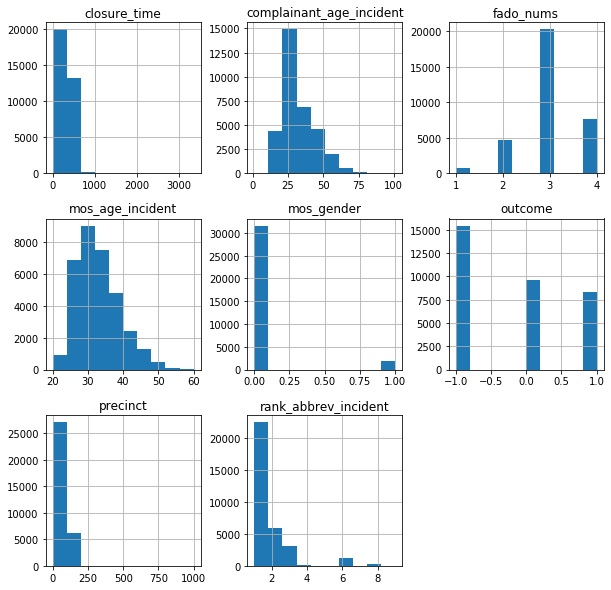

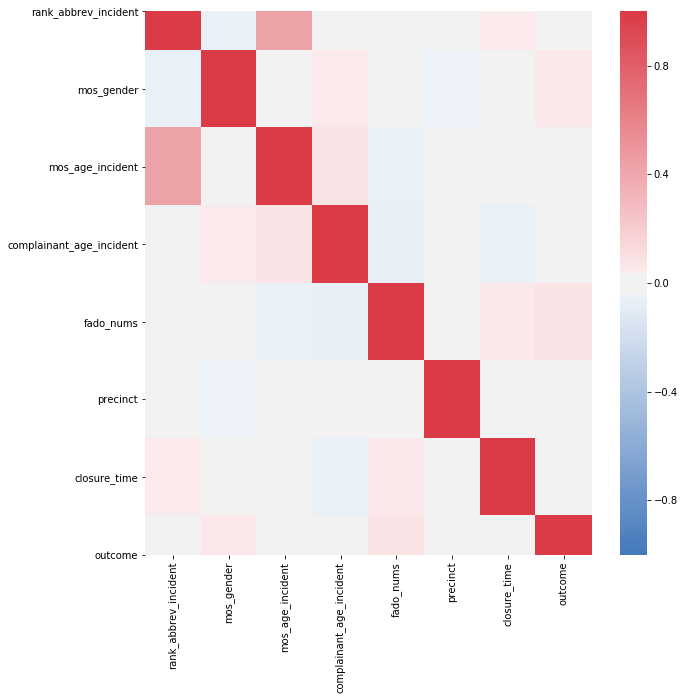

In [26]:
generate_basic_exploration(sub_df)

In [152]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'same_ethnicity', 'same_gender', 'male', 'female', 'trans_man',
       'trans_woman', 'non_conforming', 'c_female', 'c_male', 'c_trans_man',
       'c_trans_woman', 'c_non_conforming', 'outcome', 'demotion', 'force',
       'words', 'power', 'rude', 'promotion', 'fado_nums'],
      dtype='object')

In [27]:
# Test run
officer_vars = (['rank_abbrev_incident', 'mos_gender', 'mos_age_incident', 
                'same_ethnicity',  'closure_time'] 
                + constructed_cols 
                + remaining_cols)
# complainant_vars = ['complainant_age_incident', 'fado_nums']
#Attempting to replace fado_nums with dummies
complainant_vars = ['complainant_age_incident', 'force', 'power', 'rude', 'words',
                    'c_male', 'c_female', 'c_trans_man', 'c_trans_woman', 
                    'c_non_conforming']
X = df[officer_vars + complainant_vars]
y = df['outcome']

In [28]:
y = y.astype(float)
for col in X:
    X[col] = X[col].astype(float)

C:\Users\nmpie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
X.dtypes

rank_abbrev_incident        float64
mos_gender                  float64
mos_age_incident            float64
same_ethnicity              float64
same_gender                 float64
complainant_age_incident    float64
c_trans_man                 float64
c_trans_woman               float64
c_non_conforming            float64
fado_nums                   float64
dtype: object

In [29]:
def train_test_split(X, y, train_size, random_seed=0):
    random.seed(random_seed)
    all_inds = list(range(len(y)))
    train_inds = random.sample(range(len(y)), train_size)
    test_inds = [x for x in all_inds if x not in train_inds]
    train_X = X.iloc[train_inds]
    train_Y = y[train_inds]
    test_X = X.iloc[test_inds]
    test_Y = y[test_inds]
    return train_X, train_Y, test_X, test_Y

In [30]:
train_X, train_y, test_X, test_y = train_test_split(X, y, round(len(y)*0.8))

In [31]:
w_hat = la.inv(train_X.T@train_X)@train_X.T@train_y
w_hat
#Female officers has a positive coefficient on substantiated claims

0    -0.021409
1     0.166915
2     0.001800
3    -0.034833
4    -0.000181
5     0.000180
6    -0.089643
7    -0.053877
8    -0.033014
9    -0.168191
10    0.156669
11    0.006213
12    0.039921
13    0.020275
14    0.043829
15    0.138168
16    0.102906
17    0.093635
18    0.046700
19    0.091256
20   -0.385602
21    0.050274
22   -0.070439
23   -0.346907
24   -0.010683
25    0.007606
26   -0.119848
27   -0.058113
28    0.068419
29   -0.300522
30   -0.475297
31   -0.438022
32   -1.021989
33   -0.033416
34   -0.112102
35   -0.908065
36   -0.112816
37   -0.019763
38    0.133197
39   -0.315758
40   -0.225629
41   -0.258348
42    0.562219
43    0.094094
44    0.028055
45    0.059255
46   -0.405783
47    0.204574
48   -0.086834
49    0.141403
50   -0.000269
51   -0.119937
52    0.029666
53   -0.361413
54   -0.520083
55   -0.122536
56   -0.203899
57    0.038485
58    0.462263
59    0.933488
dtype: float64

In [32]:
train_preds = np.array(train_X)@np.array(w_hat)
train_preds = [-1 if x < -0.5 else x for x in train_preds]
train_preds = [1 if x > 0.5 else x for x in train_preds]
train_preds = [0 if x not in (-1, 1) else x for x in train_preds]

# predictions = np.array(test_X)@np.array(w_hat)
print(test_X.shape, w_hat.shape)
predictions = np.array(test_X)@np.array(w_hat)
predictions = [np.round(x) for x in predictions]

(6672, 60) (60,)


In [33]:
sum(predictions)

-671.0

In [34]:
train_error = ((np.array(train_preds)-train_y)**2).mean()
mean_squared_error = ((np.array(predictions)-test_y)**2).mean()
train_error, mean_squared_error

(0.6841040245821779, 0.6804556354916067)

<IPython.core.display.Javascript object>


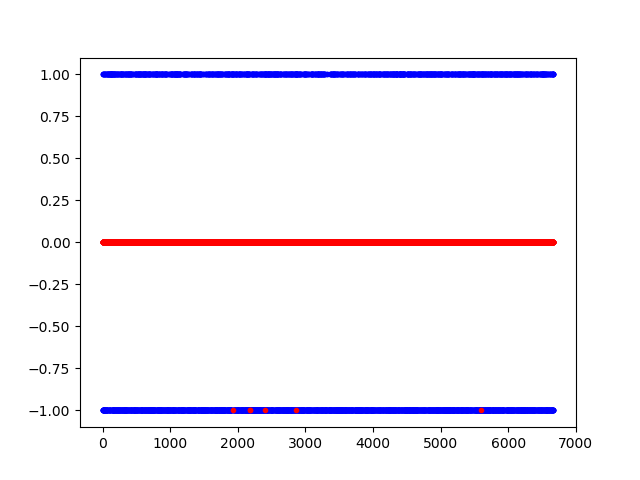

In [273]:
%matplotlib notebook
fig = plt.figure(1)
ax = fig.add_subplot(111)
p = ax.plot(range(len(test_y)), np.array(test_y), 'b.', range(len(test_y)), np.array(predictions), 'r.')


In [274]:
np.round(-.6)

-1.0